## SPY Options Market Microstructure EDA (2025–2026)
This section quantifies:
 - Observation density by moneyness and DTE
 - Volume concentration by moneyness and DTE
 - Bid-ask spreads (relative) as a liquidity proxy
 - Liquidity heatmap by (DTE bucket × moneyness bucket)

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

df = pd.read_csv(
    "/Users/karandeepsonewane/Projects/Option Pricing using Neural Network/data/spy_option/processed/option_chain_with_vix.csv"
)

df.head()

,Unnamed: 0,optionSymbol,expiration,dte,intrinsicValue,extrinsicValue,strike,bid,ask,mid,underlyingPrice,spot_price,snapshot_date,volume,inTheMoney,t_ann,M,VIX,C,C/K,sigma
0,0,SPY250103C00300000,1735938900,1.0,284.64,0.335,300.0,284.36,285.59,284.975,584.64,584.64,2025-01-02,0,True,0.002740,0.667214,NaN,284.975,0.949917,0.1735
1,1,SPY250718C00605000,1752869700,197.0,0.00,20.670,605.0,20.61,20.73,20.670,584.64,584.64,2025-01-02,25,False,0.539726,-0.034232,NaN,20.670,0.034165,0.1735
2,2,SPY250718C00610000,1752869700,197.0,0.00,18.000,610.0,17.95,18.05,18.000,584.64,584.64,2025-01-02,44,False,0.539726,-0.042463,NaN,18.000,0.029508,0.1735
3,3,SPY250718C00615000,1752869700,197.0,0.00,15.525,615.0,15.47,15.58,15.525,584.64,584.64,2025-01-02,10,False,0.539726,-0.050626,NaN,15.525,0.025244,0.1735
4,4,SPY250718C00620000,1752869700,197.0,0.00,13.280,620.0,13.24,13.32,13.280,584.64,584.64,2025-01-02,24,False,0.539726,-0.058723,NaN,13.280,0.021419,0.1735


### Cleaning and Dataset Scope


In [ ]:
df["snapshot_date"] = pd.to_datetime(df["snapshot_date"], errors="coerce")
df = df.sort_values("snapshot_date")

print(f"Date range: {df['snapshot_date'].min()} → {df['snapshot_date'].max()}")
print(f"Total rows: {len(df):,}")
print(f"Trading days: {df['snapshot_date'].nunique():,}")

# Keep rows with valid quotes
df = df[df["bid"].notna() & df["ask"].notna()]
df = df[df["ask"] >= df["bid"]]

print(f"Rows after valid bid/ask filter: {len(df):,}")

Date range: 2025-01-02 00:00:00 → 2026-02-03 00:00:00
Total rows: 1,261,616
Trading days: 272
Rows after valid bid/ask filter: 1,261,616


In [41]:
# monyeness by bucket
bins_m = [-np.inf, -0.2, -0.05, 0.05, 0.2, np.inf]
labels_m = ["deep OTM", "OTM", "ATM", "ITM", "deep ITM"]
df["M_bucket"] = pd.cut(df["M"], bins=bins_m, labels=labels_m, include_lowest=True)

# DTE buckets (days)
df["dte"] = pd.to_numeric(df["dte"], errors="coerce")
bins_dte = [0, 7, 30, 90, 252, 756, np.inf]
labels_dte = ["0-7d", "8-30d", "31-90d", "91-252d", "253-756d", ">756d"]
df["DTE_bucket"] = pd.cut(df["dte"], bins=bins_dte, labels=labels_dte, include_lowest=True)

df[["M", "M_bucket", "dte", "DTE_bucket"]].head()

,M,M_bucket,dte,DTE_bucket
0,0.667214,deep ITM,1.0,0-7d
2943,0.571904,deep ITM,1.0,0-7d
2944,0.542051,deep ITM,1.0,0-7d
2945,0.513063,deep ITM,1.0,0-7d
2946,0.484892,deep ITM,1.0,0-7d


In [42]:
obs_by_m = (
    df.groupby("M_bucket", observed=True)
      .size()
      .rename("num_observations")
      .reset_index()
)
obs_by_m["pct_observations"] = obs_by_m["num_observations"] / obs_by_m["num_observations"].sum() * 100
obs_by_m

,M_bucket,num_observations,pct_observations
0,deep OTM,110326,8.744816
1,OTM,196964,15.612040
2,ATM,323005,25.602481
3,ITM,294482,23.341651
4,deep ITM,336839,26.699011


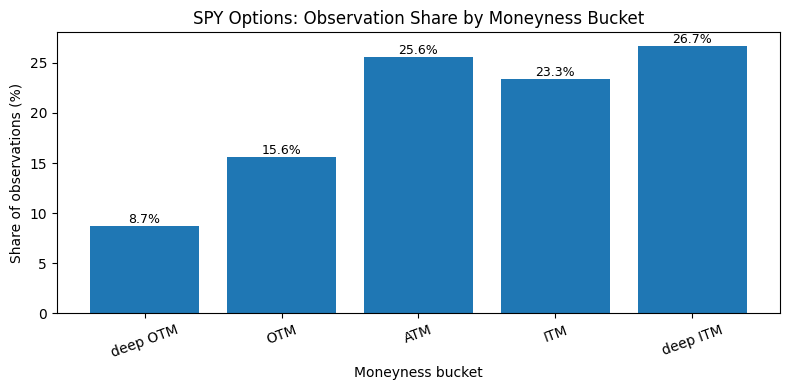

In [43]:
# Bar plot: observation share by bucket
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(obs_by_m["M_bucket"].astype(str), obs_by_m["pct_observations"])

ax.set_title("SPY Options: Observation Share by Moneyness Bucket")
ax.set_xlabel("Moneyness bucket")
ax.set_ylabel("Share of observations (%)")
plt.xticks(rotation=20)

# annotate
for i, v in enumerate(obs_by_m["pct_observations"].values):
    ax.text(i, v + 0.3, f"{v:.1f}%", ha="center", fontsize=9)

plt.tight_layout()
plt.show()

### Volume Concentration by Moneyness

In [44]:
# volume 
vol_by_m = (
    df.groupby("M_bucket", observed=True)["volume"]
      .sum()
      .rename("total_volume")
      .reset_index()
)
vol_by_m["pct_volume"] = vol_by_m["total_volume"] / vol_by_m["total_volume"].sum() * 100
vol_by_m

,M_bucket,total_volume,pct_volume
0,deep OTM,5991466,1.418901
1,OTM,36921085,8.743661
2,ATM,370297540,87.693960
3,ITM,7549387,1.787848
4,deep ITM,1501691,0.355631


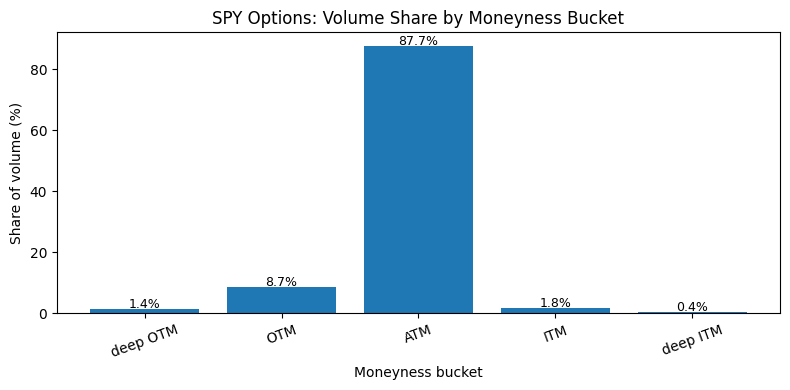

In [ ]:
# by volume 
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(vol_by_m["M_bucket"].astype(str), vol_by_m["pct_volume"])

ax.set_title("SPY Options: Volume Share by Moneyness Bucket")
ax.set_xlabel("Moneyness bucket")
ax.set_ylabel("Share of volume (%)")
plt.xticks(rotation=20)

for i, v in enumerate(vol_by_m["pct_volume"].values):
    ax.text(i, v + 0.3, f"{v:.1f}%", ha="center", fontsize=9)

plt.tight_layout()
plt.show()

## Volume Concentration by DTE

In [47]:
vol_by_dte = (
    df.groupby("DTE_bucket", observed=True)["volume"]
      .sum()
      .rename("total_volume")
      .reset_index()
)
vol_by_dte["pct_volume"] = vol_by_dte["total_volume"] / vol_by_dte["total_volume"].sum() * 100
vol_by_dte

,DTE_bucket,total_volume,pct_volume
0,0-7d,298742223,70.748211
1,8-30d,71176296,16.855989
2,31-90d,32008892,7.580354
3,91-252d,13399837,3.173353
4,253-756d,6467715,1.531686
5,>756d,466206,0.110407


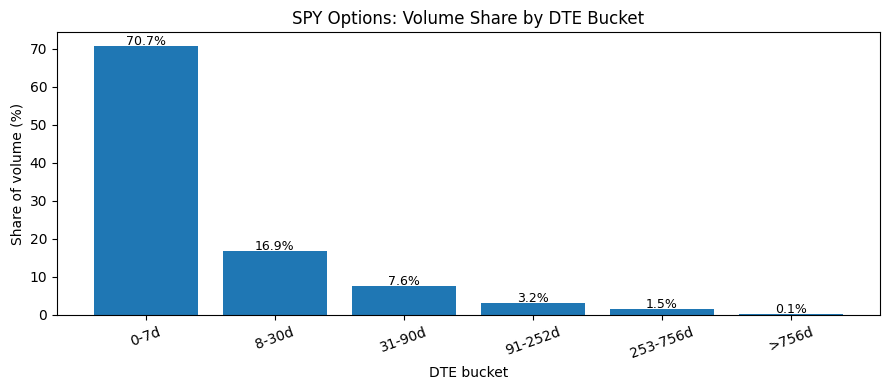

In [48]:
# %%
fig, ax = plt.subplots(figsize=(9, 4))
ax.bar(vol_by_dte["DTE_bucket"].astype(str), vol_by_dte["pct_volume"])

ax.set_title("SPY Options: Volume Share by DTE Bucket")
ax.set_xlabel("DTE bucket")
ax.set_ylabel("Share of volume (%)")
plt.xticks(rotation=20)

for i, v in enumerate(vol_by_dte["pct_volume"].values):
    ax.text(i, v + 0.3, f"{v:.1f}%", ha="center", fontsize=9)

plt.tight_layout()
plt.show()

### Liquidity Proxy: Relative Bid–Ask Spread

In [49]:
# We compute:
# - Absolute spread = ask - bid
# - Relative spread = (ask - bid) / mid
# Relative spread is scale-free and comparable across strikes/expiries.

# mid price (use existing mid if present; else compute)
mid = df["mid"] if "mid" in df.columns else (df["ask"] + df["bid"]) / 2

df["spread_abs"] = df["ask"] - df["bid"]
df["spread_rel"] = df["spread_abs"] / mid

# sanity filter: avoid extreme divides (mid<=0)
df = df[mid > 0].copy()

df[["bid", "ask", "spread_abs", "spread_rel"]].describe(percentiles=[0.25, 0.5, 0.75])

,bid,ask,spread_abs,spread_rel
count,1.261363e+06,1.261363e+06,1.261363e+06,1.261363e+06
mean,9.010811e+01,9.140256e+01,1.294452e+00,1.343859e-01
std,1.111733e+02,1.123082e+02,1.519468e+00,4.175246e-01
min,0.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00
25%,5.030000e+00,5.170000e+00,5.000000e-02,7.878112e-03
50%,4.703000e+01,4.807000e+01,5.700000e-01,1.453270e-02
75%,1.339700e+02,1.362300e+02,2.700000e+00,3.174603e-02
max,6.435000e+02,6.484600e+02,3.000000e+01,2.000000e+00


###  Spread by Moneyness Bucket

In [50]:
# spread by moneyness
spread_by_m = (
    df.groupby("M_bucket", observed=True)["spread_rel"]
      .agg(
          median="median",
          p25=lambda x: x.quantile(0.25),
          p75=lambda x: x.quantile(0.75),
          count="size"
      )
      .reset_index()
)

spread_by_m

,M_bucket,median,p25,p75,count
0,deep OTM,0.097087,0.033839,0.390805,110326
1,OTM,0.039216,0.011523,0.545455,196964
2,ATM,0.009811,0.005457,0.023448,323005
3,ITM,0.014562,0.007311,0.029234,294482
4,deep ITM,0.012347,0.008429,0.016888,336586


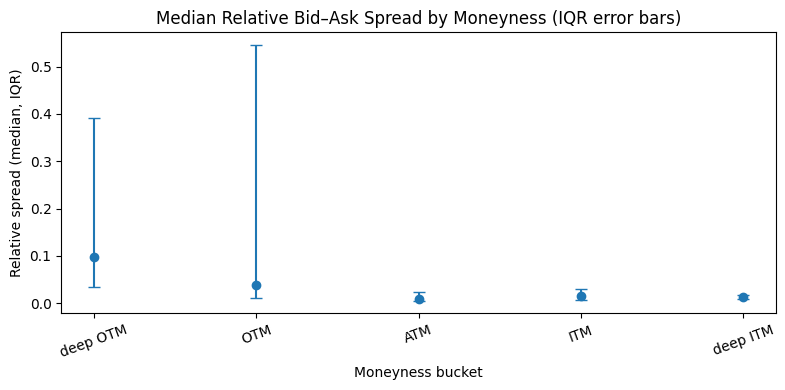

In [51]:
# Plot median spread with IQR error bars
x = np.arange(len(spread_by_m))
med = spread_by_m["median"].values
p25 = spread_by_m["p25"].values
p75 = spread_by_m["p75"].values

fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(
    x, med,
    yerr=[med - p25, p75 - med],
    fmt="o",
    capsize=4
)

ax.set_xticks(x)
ax.set_xticklabels(spread_by_m["M_bucket"].astype(str), rotation=20)
ax.set_title("Median Relative Bid–Ask Spread by Moneyness (IQR error bars)")
ax.set_xlabel("Moneyness bucket")
ax.set_ylabel("Relative spread (median, IQR)")
plt.tight_layout()
plt.show()

In [52]:
# Spread by DTE Bucket
spread_by_dte = (
    df.groupby("DTE_bucket", observed=True)["spread_rel"]
      .agg(
          median="median",
          p25=lambda x: x.quantile(0.25),
          p75=lambda x: x.quantile(0.75),
          count="size"
      )
      .reset_index()
)

spread_by_dte

,DTE_bucket,median,p25,p75,count
0,0-7d,0.026589,0.011083,0.285714,191356
1,8-30d,0.015773,0.006192,0.048709,238102
2,31-90d,0.012285,0.006137,0.025798,228050
3,91-252d,0.011696,0.007178,0.020429,288856
4,253-756d,0.014134,0.009008,0.024724,255497
5,>756d,0.020264,0.012741,0.036337,59502


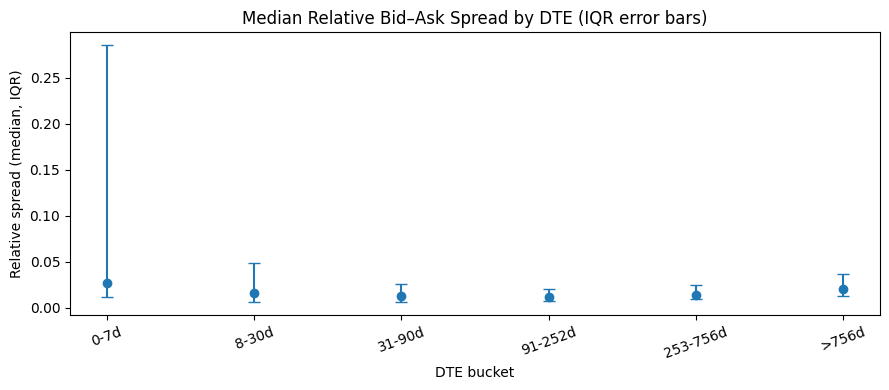

In [54]:
# spread by dte
x = np.arange(len(spread_by_dte))
med = spread_by_dte["median"].values
p25 = spread_by_dte["p25"].values
p75 = spread_by_dte["p75"].values

fig, ax = plt.subplots(figsize=(9, 4))
ax.errorbar(
    x, med,
    yerr=[med - p25, p75 - med],
    fmt="o",
    capsize=4
)

ax.set_xticks(x)
ax.set_xticklabels(spread_by_dte["DTE_bucket"].astype(str), rotation=20)
ax.set_title("Median Relative Bid–Ask Spread by DTE (IQR error bars)")
ax.set_xlabel("DTE bucket")
ax.set_ylabel("Relative spread (median, IQR)")
plt.tight_layout()
plt.show()

### Liquidity Heatmap

In [57]:
pivot = df.pivot_table(
    index="DTE_bucket",
    columns="M_bucket",
    values="spread_rel",
    aggfunc="median"
)

pivot

/var/folders/_v/vfbxc80973l9zq3s4w559dzm0000gn/T/ipykernel_58428/2910154743.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


M_bucket,deep OTM,OTM,ATM,ITM,deep ITM
DTE_bucket,,,,,
0-7d,2.000000,2.000000,0.019417,0.028516,0.012624
8-30d,2.000000,0.666667,0.009693,0.017561,0.011098
31-90d,0.666667,0.045455,0.005797,0.015537,0.011380
91-252d,0.181818,0.016000,0.007249,0.009852,0.012070
253-756d,0.051282,0.008538,0.012912,0.010971,0.012852
>756d,0.041995,0.011181,0.039294,0.028582,0.014180


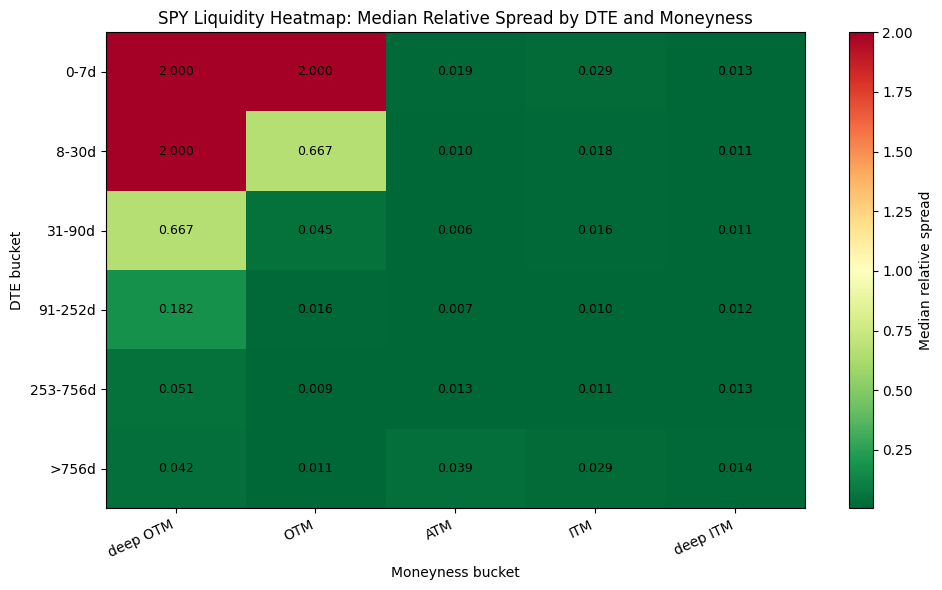

In [59]:
# heatmap
fig, ax = plt.subplots(figsize=(10, 6))

data = pivot.values.astype(float)
im = ax.imshow(data, aspect="auto", cmap="RdYlGn_r")

# axis labels
ax.set_xticks(np.arange(pivot.shape[1]))
ax.set_yticks(np.arange(pivot.shape[0]))
ax.set_xticklabels(pivot.columns.astype(str))
ax.set_yticklabels(pivot.index.astype(str))
plt.setp(ax.get_xticklabels(), rotation=25, ha="right")

# colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Median relative spread")

# annotate cells
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        val = pivot.iloc[i, j]
        if np.isfinite(val):
            ax.text(j, i, f"{val:.3f}", ha="center", va="center", fontsize=9)

ax.set_title("SPY Liquidity Heatmap: Median Relative Spread by DTE and Moneyness")
ax.set_xlabel("Moneyness bucket")
ax.set_ylabel("DTE bucket")

plt.tight_layout()
plt.show()